In [2]:
%matplotlib inline

import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltools.data import Brain_Data
from nltools.mask import expand_mask
from bids import BIDSLayout, BIDSValidator

#data_dir = '/mnt/chrastil/lab/users/lily/localizer_beta_series_run_trials_only'
#data_dir = '/mnt/chrastil/lab/users/lily/localizer_beta_series_all_run_exploration'
#data_dir = '/mnt/chrastil/lab/users/lily/localizer_beta_series_all_exploration'
#data_dir = '/mnt/chrastil/lab/users/lily/path_direction/localizer_beta_series_run_trials_only'
# data_dir = '/mnt/chrastil/lab/users/lily/path_direction/localizer_beta_series_all_exploration'
data_dir = '/mnt/chrastil/lab/users/lily/path_direction/localizer_beta_series_all_run_exploration'

# layout = BIDSLayout(data_dir, derivatives=True)

In [3]:
from nltools.utils import get_resource_path
from nltools.file_reader import onsets_to_dm
from nltools.data import Design_Matrix
import os

In [4]:
sub_num = 'sub-033'

## All trials

In [5]:
E_file_list = glob.glob(os.path.join(data_dir, 'derivatives', 'nibetaseries',sub_num,'func','*Ex*_desc-E*.nii.gz'))
E_file_list.sort() 
E = Brain_Data(E_file_list)

N_file_list = glob.glob(os.path.join(data_dir,  'derivatives', 'nibetaseries',sub_num,'func','*Ex*_desc-N*.nii.gz'))
N_file_list.sort()
N = Brain_Data(N_file_list)

W_file_list = glob.glob(os.path.join(data_dir, 'derivatives', 'nibetaseries',sub_num,'func','*Ex*_desc-W*.nii.gz'))
W_file_list.sort() 
W = Brain_Data(W_file_list)

S_file_list = glob.glob(os.path.join(data_dir, 'derivatives', 'nibetaseries',sub_num,'func','*Ex*_desc-S*.nii.gz'))
S_file_list.sort() 
S = Brain_Data(S_file_list)

In [6]:
data = E.append(N)
data = data.append(W)
data = data.append(S)

In [7]:
print(len(E.data))
print(len(N.data))
print(len(W.data))
print(len(S.data))

62
44
40
31


In [8]:
#Y = pd.DataFrame(np.hstack([np.zeros(157), np.ones(119),2*np.ones(122), 3*np.ones(97)]))
Y = pd.DataFrame(np.hstack([np.zeros(len(E.data)), np.ones(len(N.data)),2*np.ones(len(W.data)), 3*np.ones(len(S.data))]))

#Y = pd.DataFrame(np.hstack([np.zeros(42), np.ones(44)]))

data.Y = Y

# test

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, LeaveOneOut, GridSearchCV, cross_val_score
from sklearn.svm import SVC
from nltools.data import Brain_Data
from sklearn.model_selection import permutation_test_score

In [ ]:
X = data.data
y = data.Y.values.ravel()

In [ ]:
svc = SVC(kernel = "rbf")
from sklearn.feature_selection import SelectPercentile, f_classif
feature_selection = SelectPercentile(f_classif, percentile=5)
from sklearn.pipeline import Pipeline
# anova_svc = Pipeline([('anova', feature_selection), ('svc', svc)])

# anova_svc = Pipeline([('anova', feature_selection), ('svc', svc)])
# svc.fit(X, y)

In [ ]:
kfold = KFold(n_splits = 10, shuffle = True, random_state = 0)

loo = LeaveOneOut()
cv_scores = cross_val_score(svc, X, y, cv= kfold)
# cv_scores = cross_val_score(anova_svc, data.data, data.Y.values.ravel(), cv=5)


In [ ]:
cv_scores.mean()

In [ ]:
pip install joblib

In [ ]:

null_cv_scores, value2, value3 = permutation_test_score(
    svc, X, y, scoring="accuracy", cv=kfold)


In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.hist(value2, bins=20, density=True)
ax.axvline(null_cv_scores, ls='--', color='r')
score_label = (f"Score on original\ndata: {null_cv_scores:.2f}\n"
               f"(p-value: {value3:.3f})")
ax.text(0.7, 260, score_label, fontsize=12)
ax.set_xlabel("Accuracy score")
_ = ax.set_ylabel("Probability")

# Feature Selection - Whole Brain Analysis

In [ ]:
# ------------------
# Define the prediction function to be used.
# Here we use a Support Vector Classification, with a linear kernel
from sklearn.svm import SVC
svc = SVC(kernel='linear')

# Define the dimension reduction to be used.
# Here we use a classical univariate feature selection based on F-test,
# namely Anova. When doing full-brain analysis, it is better to use
# SelectPercentile, keeping 5% of voxels
# (because it is independent of the resolution of the data).
from sklearn.feature_selection import SelectPercentile, f_classif
feature_selection = SelectPercentile(f_classif, percentile=5)

# We have our classifier (SVC), our feature selection (SelectPercentile),and now,
# we can plug them together in a *pipeline* that performs the two operations
# successively:
from sklearn.pipeline import Pipeline
anova_svc = Pipeline([('anova', feature_selection), ('svc', svc)])

In [ ]:
#############################################################################
# Fit the decoder and predict
# ----------------------------
anova_svc.fit(data.data, data.Y.values.ravel())
y_pred = anova_svc.predict(data.data)

In [ ]:
#############################################################################
# Obtain prediction scores via cross validation
# -----------------------------------------------
from sklearn.model_selection import LeaveOneGroupOut, cross_val_score

# Define the cross-validation scheme used for validation.
# Here we use a LeaveOneGroupOut cross-validation on the session group
# which corresponds to a leave-one-session-out
#cv = LeaveOneGroupOut()


# Compute the prediction accuracy for the different folds (i.e. session)
#cv_scores = cross_val_score(anova_svc, data.data, data.Y, cv=cv, groups=4)
cv_scores = cross_val_score(anova_svc, data.data, data.Y.values.ravel(), cv=5)

# Return the corresponding mean prediction accuracy
classification_accuracy = cv_scores.mean()

# Print the results
print("Classification accuracy: %.4f / Chance level: %f" %
      (classification_accuracy, 1. / len(data.Y[0].unique())))
# Classification accuracy:  0.70370 / Chance level: 0.5000


#############################################################################

# roi - thalamus

In [10]:
atlas_mni_file = os.path.join(data_dir,
                              "derivatives",
                              "data",
                              "HarvardOxford-sub-maxprob-thr25-1mm.nii.gz")

threshold is ignored for simple axial plots


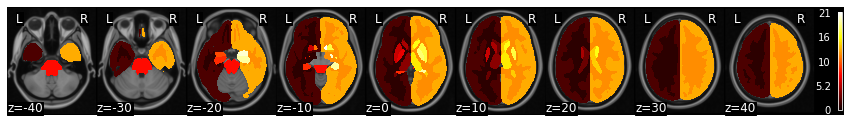

In [11]:
mask = Brain_Data(atlas_mni_file)
mask_x = expand_mask(mask)

f = mask.plot()

In [12]:
# index - 1 for all because this is python!!!
tha = mask_x[[4-1,15-1]].sum() # thalamus

data_masked = data.apply_mask(tha)


In [ ]:
anova_svc = Pipeline([('anova', feature_selection), ('svc', svc)])
anova_svc.fit(data_masked.data, data_masked.Y.values.ravel())
y_pred = anova_svc.predict(data_masked.data)

In [ ]:
cv_scores = cross_val_score(anova_svc, data_masked.data, data_masked.Y.values.ravel(), cv=5)

# Return the corresponding mean prediction accuracy
classification_accuracy = cv_scores.mean()

# Print the results
print("Classification accuracy: %.4f / Chandata_maskedce level: %f" %
      (classification_accuracy, 1. / len(data.Y[0].unique())))

# New Algorithm

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, LeaveOneOut, GridSearchCV

In [13]:
X = data_masked.data
Y = data_masked.Y.values.ravel()

In [ ]:
print(X.shape)
print(y.shape)

In [ ]:
loo = LeaveOneOut()
X_std = MinMaxScaler().fit_transform(X)
svc = SVC(kernel = "rbf",C = 0.001, gamma = 0.001)

cv_scores = cross_val_score(svc, X_std, Y, cv= loo)

classification_accuracy = cv_scores.mean()
print(classification_accuracy)

In [ ]:
kfold = KFold(n_splits = 10, shuffle = True, random_state = 0)

In [ ]:
import random

In [ ]:
Y

In [ ]:
Z = Y.copy()

In [ ]:
random.shuffle(Z)

In [ ]:
print(Z)

In [ ]:
cv_scores = cross_val_score(svc, X_std, Y, cv= kfold)
classification_accuracy = cv_scores.mean()
print(classification_accuracy)

In [ ]:
print(null_cv_scores)
print(value2)
print(value3)

In [ ]:
value2.mean()

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.hist(value2, bins=20, density=True)
ax.axvline(null_cv_scores, ls='--', color='r')
score_label = (f"Score on original\ndata: {null_cv_scores:.2f}\n"
               f"(p-value: {value3:.3f})")
ax.text(0.7, 260, score_label, fontsize=12)
ax.set_xlabel("Accuracy score")
_ = ax.set_ylabel("Probability")

# Permutation

In [ ]:
from sklearn.model_selection import permutation_test_score


In [ ]:
# null_cv_scores = permutation_test_score(
#     svc, fmri_masked, conditions, cv=cv, groups=session_label)[1]

anova_svc = Pipeline([('anova', feature_selection), ('svc', SVC(kernel = "linear"))])

null_cv_scores, value2, value3 = permutation_test_score(
    anova_svc, X, Y, scoring="accuracy", cv=loo)



In [ ]:
# print("Permutation test score: {:.3f}".format(null_cv_scores))
print(null_cv_scores)
print(value2)
print(value3)

In [ ]:
value2.mean()

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.hist(value2, bins=20, density=True)
ax.axvline(null_cv_scores, ls='--', color='r')
score_label = (f"Score on original\ndata: {null_cv_scores:.2f}\n"
               f"(p-value: {value3:.3f})")
ax.text(0.7, 260, score_label, fontsize=12)
ax.set_xlabel("Accuracy score")
_ = ax.set_ylabel("Probability")

# FREM test

In [35]:
file_name = os.path.join(data_dir, 'derivatives', 'nibetaseries',sub_num,'func','fmer_test','multi_scan.nii')

In [ ]:
'sub-033_task-boldEx2_run-1_space-MNI152NLin2009cAsym_desc-E_betaseries.nii.gz'

In [9]:
# Compute the mean epi to be used for the background of the plotting
from nilearn.image import mean_img
background_img = mean_img(S_file_list)

In [58]:
import nilearn
from nilearn.image import index_img
X = nilearn.image.load_img(E_file_list)

In [59]:
X.shape

(97, 115, 97, 62)

In [50]:
y_train = y[::2]
y_test = y[1::2]

In [41]:
X_train = X.slicer[::2]
X_test = X.slicer[1::2]

In [43]:
X_train.shape

(49, 115, 97, 89)

In [47]:
y = np.hstack([np.zeros(34), np.ones(22),2*np.ones(14), 3*np.ones(19)])

In [52]:
y_train.shape

(45,)

In [53]:
from nilearn.decoding import FREMClassifier
decoder = FREMClassifier(cv=10)
# Fit model on train data and predict on test data
decoder.fit(X_train, y_train)
y_pred = decoder.predict(X_test)
accuracy = (y_pred == y_test).mean() * 100.
print("FREM classification accuracy : %g%%" % accuracy)

ValueError: Found input variables with inconsistent numbers of samples: [89, 45]

In [ ]:
from nilearn import plotting
plotting.plot_stat_map(decoder.coef_img_["face"], background_img,
                       title="FREM: accuracy %g%%, 'face coefs'" % accuracy,
                       cut_coords=(-52, -5), display_mode="yz")
plotting.show()

# Dummy

In [ ]:
from sklearn.dummy import DummyClassifier

In [ ]:
dummy = []

for i in range(100):
    dummy[i] null_cv_scores = cross_val_score(
     DummyClassifier(), X_std, Y, scoring="accuracy", cv=loo, n_jobs = -1)



In [ ]:
print(len(null_cv_scores))

In [ ]:
# from sklearn.linear_model import Ridge
# from sklearn.feature_selection import RFE

# param_grid = {'C':[0.001,0.01,0.1,1,10,100], 'gamma':[0.001,0.01,0.1,1,10,100] }
# kfold = KFold(n_splits = 5, shuffle = True, random_state = 0)
# cv_scores = cross_val_score(GridSearchCV(SVC(), param_grid, cv = kfold, n_jobs = -1), X_std, Y, cv= loo, n_jobs = -1)

# ROI - Retrosplenial

In [ ]:
# atlas_mni_file = os.path.join(data_dir,
#                               "derivatives",
#                               "data",
#                               "Schaefer2018_100Parcels_17Networks_order_FSLMNI152_1mm.nii.gz")

In [ ]:
# mask = Brain_Data(atlas_mni_file)
# mask_x = expand_mask(mask)

# f = mask.plot()

In [ ]:
# # index - 1 for all because this is python!!!
# rsc = mask_x[[48-1,96-1]].sum() # retrosplenial cortex

# data_masked = data.apply_mask(rsc)

In [ ]:
# anova_svc = Pipeline([('anova', feature_selection), ('svc', svc)])
# anova_svc.fit(data_masked.data, data_masked.Y.values.ravel())
# y_pred = anova_svc.predict(data_masked.data)

In [ ]:
# cv_scores = cross_val_score(anova_svc, data_masked.data, data_masked.Y.values.ravel(), cv=5)

# # Return the corresponding mean prediction accuracy
# classification_accuracy = cv_scores.mean()

# # Print the results
# print("Classification accuracy: %.4f / Chandata_maskedce level: %f" %
#       (classification_accuracy, 1. / len(data.Y[0].unique())))

# ROI - Precuneus

In [ ]:
# # index - 1 for all because this is python!!!
# pcun = mask_x[[35-1,36-1]].sum() # precuneus

# data_masked = data.apply_mask(pcun)

In [ ]:
# anova_svc = Pipeline([('anova', feature_selection), ('svc', svc)])
# anova_svc.fit(data_masked.data, data_masked.Y.values.ravel())
# y_pred = anova_svc.predict(data_masked.data)

In [ ]:
# cv_scores = cross_val_score(anova_svc, data_masked.data, data_masked.Y.values.ravel(), cv=5)

# # Return the corresponding mean prediction accuracy
# classification_accuracy = cv_scores.mean()

# # Print the results
# print("Classification accuracy: %.4f / Chandata_maskedce level: %f" %
#       (classification_accuracy, 1. / len(data.Y[0].unique())))

# ROI - Medial Parietal Lobe

In [ ]:
# # index - 1 for all because this is python!!!

# mpar = mask_x[[24-1,73-1]].sum() # medial parietal lobe

# data_masked = data.apply_mask(mpar)

In [ ]:
# anova_svc = Pipeline([('anova', feature_selection), ('svc', svc)])
# anova_svc.fit(data_masked.data, data_masked.Y.values.ravel())
# y_pred = anova_svc.predict(data_masked.data)

In [ ]:
# cv_scores = cross_val_score(anova_svc, data_masked.data, data_masked.Y.values.ravel(), cv=5)

# # Return the corresponding mean prediction accuracy
# classification_accuracy = cv_scores.mean()

# # Print the results
# print("Classification accuracy: %.4f / Chandata_maskedce level: %f" %
#       (classification_accuracy, 1. / len(data.Y[0].unique())))

# ROI - Intraparietal Sulcus

In [ ]:
# # index - 1 for all because this is python!!!

# ips = mask_x[[31-1,80-1]].sum() # intrapariental sulcus

# data_masked = data.apply_mask(ips)

In [ ]:
# anova_svc = Pipeline([('anova', feature_selection), ('svc', svc)])
# anova_svc.fit(data_masked.data, data_masked.Y.values.ravel())
# y_pred = anova_svc.predict(data_masked.data)

In [ ]:
# cv_scores = cross_val_score(anova_svc, data_masked.data, data_masked.Y.values.ravel(), cv=5)

# # Return the corresponding mean prediction accuracy
# classification_accuracy = cv_scores.mean()

# # Print the results
# print("Classification accuracy: %.4f / Chandata_maskedce level: %f" %
#       (classification_accuracy, 1. / len(data.Y[0].unique())))

# ROI - Extrastriate Cortex

In [ ]:
# # index - 1 for all because this is python!!!

# ext = mask_x[[1-1,2-1,4-1,51-1,52-1,53-1]].sum() # extrastriate cortex

# data_masked = data.apply_mask(ext)

In [ ]:
# anova_svc = Pipeline([('anova', feature_selection), ('svc', svc)])
# anova_svc.fit(data_masked.data, data_masked.Y.values.ravel())
# y_pred = anova_svc.predict(data_masked.data)

In [ ]:
# cv_scores = cross_val_score(anova_svc, data_masked.data, data_masked.Y.values.ravel(), cv=5)

# # Return the corresponding mean prediction accuracy
# classification_accuracy = cv_scores.mean()

# # Print the results
# print("Classification accuracy: %.4f / Chandata_maskedce level: %f" %
#       (classification_accuracy, 1. / len(data.Y[0].unique())))

# ROI - Parahippocampus

In [ ]:
# # index - 1 for all because this is python!!!

# phc = mask_x[[49-1,97-1]].sum() # parahippocampus


# data_masked = data.apply_mask(phc)


In [ ]:
# anova_svc = Pipeline([('anova', feature_selection), ('svc', svc)])
# anova_svc.fit(data_masked.data, data_masked.Y.values.ravel())
# y_pred = anova_svc.predict(data_masked.data)

In [ ]:
# cv_scores = cross_val_score(anova_svc, data_masked.data, data_masked.Y.values.ravel(), cv=5)

# # Return the corresponding mean prediction accuracy
# classification_accuracy = cv_scores.mean()

# # Print the results
# print("Classification accuracy: %.4f / Chandata_maskedce level: %f" %
#       (classification_accuracy, 1. / len(data.Y[0].unique())))

# ROI - Somatomotor Cortex

In [ ]:
# index - 1 for all because this is python!!!

# som = mask_x[[8-1,9-1,10-1,11-1,12-1,13-1,57-1,58-1,59-1,60-1,61-1,62-1,63-1,64-1]].sum() # somatomotor



# data_masked = data.apply_mask(som)


In [ ]:
# anova_svc = Pipeline([('anova', feature_selection), ('svc', svc)])
# anova_svc.fit(data_masked.data, data_masked.Y.values.ravel())
# y_pred = anova_svc.predict(data_masked.data)

In [ ]:
# cv_scores = cross_val_score(anova_svc, data_masked.data, data_masked.Y.values.ravel(), cv=5)

# # Return the corresponding mean prediction accuracy
# classification_accuracy = cv_scores.mean()

# # Print the results
# print("Classification accuracy: %.4f / Chandata_maskedce level: %f" %
#       (classification_accuracy, 1. / len(data.Y[0].unique())))

# ROI - Temporal + Temporoparietal lobe

In [ ]:
# # index - 1 for all because this is python!!!

# temp = mask_x[[41-1,42-1,50-1, 98-1,99-1,100-1]].sum() # temporal lobe, temporal parietal lobe

# data_masked = data.apply_mask(temp)

In [ ]:
# anova_svc = Pipeline([('anova', feature_selection), ('svc', svc)])
# anova_svc.fit(data_masked.data, data_masked.Y.values.ravel())
# y_pred = anova_svc.predict(data_masked.data)

In [ ]:
# cv_scores = cross_val_score(anova_svc, data_masked.data, data_masked.Y.values.ravel(), cv=5)

# # Return the corresponding mean prediction accuracy
# classification_accuracy = cv_scores.mean()

# # Print the results
# print("Classification accuracy: %.4f / Chandata_maskedce level: %f" %
#       (classification_accuracy, 1. / len(data.Y[0].unique())))